In [1]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms

In [2]:
from sklearn.model_selection import train_test_split
from PIL import Image
import os

dataset_path = './dataset/UTKFace/'
file_list = os.listdir(dataset_path)

ages = [int(file.split('_')[0]) for file in file_list]
genders = [int(file.split('_')[1]) for file in file_list]  # 0 for Male, 1 for Female
df = pd.DataFrame({'filename': file_list, 'age': ages, 'gender': genders})

proj_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df, val_df = train_test_split(proj_df, test_size=0.3, random_state=42)

#proj_df, test_df = train_test_split(df, test_size=0.3, stratify=df['gender'], random_state=42)

#train_df, val_df = train_test_split(proj_df, test_size=0.3, stratify=proj_df['gender'], random_state=42)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

mean = [0.59609047, 0.4563706, 0.3906234];
std = [0.21890544, 0.19489454, 0.18570753];

augmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
#    transforms.Normalize(mean=mean, std=std)
])

class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        age = self.dataframe.iloc[idx, 1]
        gender = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, gender, age

base_train_dataset = UTKFaceDataset(dataframe=train_df, root_dir=dataset_path, transform=transform)
aug_train_dataset = UTKFaceDataset(dataframe=train_df, root_dir=dataset_path, transform=augmentation_transform)
train_dataset = ConcatDataset([base_train_dataset, aug_train_dataset])

val_dataset = UTKFaceDataset(dataframe=val_df, root_dir=dataset_path, transform=transform)
test_dataset = UTKFaceDataset(dataframe=test_df, root_dir=dataset_path, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

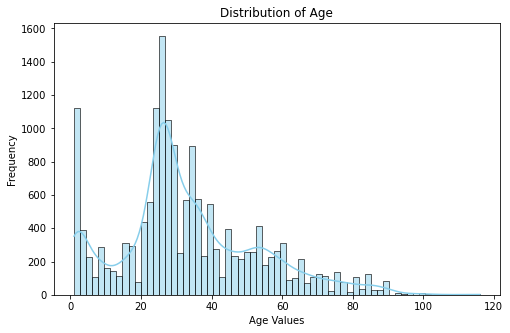

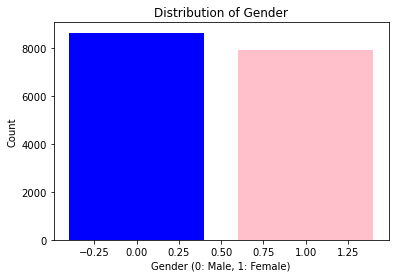

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.figure(figsize=(8, 5))
sns.histplot(proj_df['age'], kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age Values')
plt.ylabel('Frequency')
plt.show()

unique_values, counts = np.unique(proj_df['gender'], return_counts=True)

plt.bar(unique_values, counts, color=['blue', 'pink'])  # You can choose different colors
plt.title('Distribution of Gender')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')

plt.show()

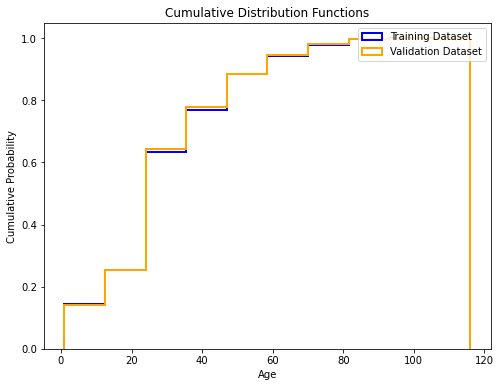

KS Statistic: 0.015340670485460395
P-value: 0.38119496384617246
The distributions are similar (fail to reject the null hypothesis)


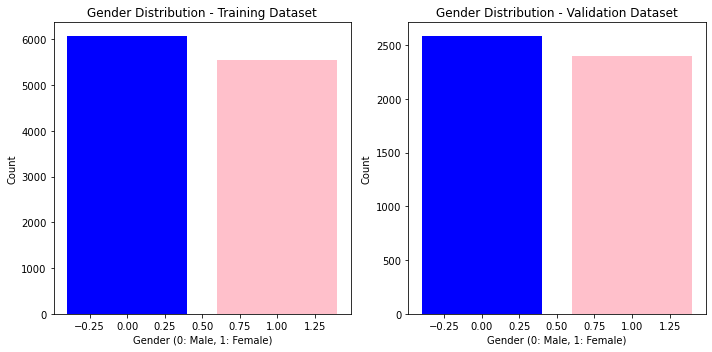

In [4]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

age_data1 = train_df['age']
age_data2 = val_df['age']
gender_data1 = train_df['gender']
gender_data2 = val_df['gender']

# Kolmogorov-Smirnov
statistic, p_value = ks_2samp(age_data1, age_data2)

# Plot the cumulative distribution functions (CDFs) for visual inspection
plt.figure(figsize=(8, 6))
plt.hist(age_data1, cumulative=True, density=True, histtype='step', label='Training Dataset', color='blue', linewidth=2)
plt.hist(age_data2, cumulative=True, density=True, histtype='step', label='Validation Dataset', color='orange', linewidth=2)
plt.title('Cumulative Distribution Functions')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # significance level
if p_value > alpha:
    print("The distributions are similar (fail to reject the null hypothesis)")
else:
    print("The distributions are different (reject the null hypothesis)")
    
plt.figure(figsize=(10, 5))

unique_values, counts = np.unique(gender_data1, return_counts=True)

plt.subplot(1, 2, 1)
plt.bar(unique_values, counts, color=['blue', 'pink'])
plt.title('Gender Distribution - Training Dataset')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')


unique_values, counts = np.unique(gender_data2, return_counts=True)

plt.subplot(1, 2, 2)
plt.bar(unique_values, counts, color=['blue', 'pink'])
plt.title('Gender Distribution - Validation Dataset')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [5]:
#mean_sum = np.zeros(3)
#std_sum = np.zeros(3)
#count = 0

#for idx, row in df.iterrows():
#    img_path = os.path.join(dataset_path, row['filename'])
#    img = Image.open(img_path).convert('RGB')
#    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    
#    mean_sum += np.mean(img_array, axis=(0, 1))
#    std_sum += np.std(img_array, axis=(0, 1))
    
#    count += 1

#mean = mean_sum / count
#std = std_sum / count

#print("Mean:", mean)
#print("Std:", std)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GenderAgeClassifier(nn.Module):
    def __init__(self):
        super(GenderAgeClassifier, self).__init__()

        # CNN architecture
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

       # Gender Branch
        self.gender_fc = nn.Sequential(
            nn.Linear(16384, 128),
            #nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        # Age Branch
        self.age_fc = nn.Sequential(
            nn.Linear(16384, 128),
            #nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        cnn_output = self.shared_cnn(x)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        gender_output = self.gender_fc(cnn_output)
        age_output = self.age_fc(cnn_output)
        
        return gender_output, age_output
    
    def get_conv_layers(self):
        return [idx for idx, layer in enumerate(self.modules()) if isinstance(layer, nn.Conv2d)]
    
    def generate_heatmaps(self, sample_images):
        # Set the model to evaluation mode
        self.cuda().eval()

        activations = []
        hooks = []
        for layer_idx in self.get_conv_layers():
            conv_layer = list(self.modules())[layer_idx]
            hook = conv_layer.register_forward_hook(self.get_activation_hook(activations))
            hooks.append(hook)

        with torch.no_grad():
            self(sample_images)

        # Remove the hooks
        for hook in hooks:
            hook.remove()

        # Calculate mean activations and create heatmaps
        mean_activations = [activation.mean(dim=1, keepdim=True) for activation in activations]
        heatmaps = [torch.nn.functional.interpolate(mean_activation, size=sample_images.shape[2:], mode='bilinear', align_corners=False) for mean_activation in mean_activations]

        return heatmaps

    def get_activation_hook(self, activations):
        def hook(module, input, output):
            activations.append(output.cpu())
        return hook

# Create the model
model = GenderAgeClassifier()

In [7]:
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
#model.load_state_dict(torch.load('gender_age_model.pth', map_location=torch.device('cpu')))

In [9]:
from sklearn.metrics import r2_score
import time

# Num of max epochs
num_epochs = 50

# Loss lists
train_loss_list = []
val_loss_list = []

# Regularization parameter
lambda_age = 0.01

# Accuracy and R2 lists
train_gender_accuracy_list = []
val_gender_accuracy_list = []
train_age_r2_list = []
val_age_r2_list = []

if torch.cuda.is_available():
    model = model.cuda()
    
# Early Stopping parameters
patience = 3
best_val_loss = float('inf')
no_improvement_count = 0

# Train the model
begin = time.time()
for epoch in range(num_epochs):
    
    correct_gender_train = 0
    total_train = 0
    train_age_r2 = 0
    
    model.train()
    
    gender_loss_sum = 0.0
    age_loss_sum = 0.0
    total_samples = 0
    
    for inputs, gender_labels, age_labels in train_loader:
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        optimizer.zero_grad()
        gender_output, age_output = model(inputs)
        
        # Move the output in the same device of gender_labels
        gender_output = gender_output.to(gender_labels.device)
        age_output = age_output.to(age_labels.device)

        # Calculate losses for both tasks
        gender_loss = criterion_gender(gender_output, gender_labels)
        age_loss = criterion_age(age_output, age_labels)
        total_samples += len(inputs)
        gender_loss_sum += gender_loss
        age_loss_sum += age_loss
        
        # Calculate total loss
        total_loss = gender_loss + lambda_age * age_loss
        
        # Backpropagation and Parameter Update
        total_loss.backward()
        optimizer.step()
        
        # Calculate gender accuracy
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_train += (predicted_gender == gender_labels).sum().item()
        total_train += gender_labels.size(0)

        # Calculate age R2
        predicted_age = age_output.detach().cpu().numpy()
        train_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)
        
    
    avg_gender_loss_sum = gender_loss_sum / total_samples
    avg_age_loss_sum = age_loss_sum / total_samples
    total_loss = avg_gender_loss_sum + avg_age_loss_sum

    train_loss_list.append(total_loss)
    
    print(f'loss_gender: {avg_gender_loss_sum} loss_age: {avg_age_loss_sum}')

    train_gender_accuracy = correct_gender_train / total_train
    train_age_r2 /= len(train_loader)
        
    # Evaluate in the Validation set
    model.eval()
    with torch.no_grad():
        
        correct_gender_val = 0
        total_val = 0
        val_age_r2 = 0
        
        val_loss_gender = 0.0
        val_loss_age = 0.0
        total_samples = 0

        for inputs, gender_labels, age_labels in val_loader:
            age_labels = age_labels.float().view(-1, 1)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                gender_labels = gender_labels.cuda()
                age_labels = age_labels.cuda()
            gender_output, age_output = model(inputs)

            # Move the output in the same device of gender_labels
            gender_output = gender_output.to(gender_labels.device)
            age_output = age_output.to(age_labels.device)
            
            val_loss_gender += criterion_gender(gender_output, gender_labels).item()
            val_loss_age += criterion_age(age_output, age_labels).item()
            total_samples += len(inputs)
            
            # Calculate gender accuracy
            _, predicted_gender = torch.max(gender_output, 1)
            correct_gender_val += (predicted_gender == gender_labels).sum().item()
            total_val += gender_labels.size(0)

            # Calculate age R2
            predicted_age = age_output.detach().cpu().numpy()
            val_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)
            
    #avg_val_loss_gender = val_loss_gender / total_samples
    #avg_val_loss_age = val_loss_age / total_samples
    avg_val_loss_gender = val_loss_gender / total_samples
    avg_val_loss_age = val_loss_age / total_samples
    total_val_loss = avg_val_loss_gender + avg_val_loss_age

    val_loss_list.append(total_val_loss)

    val_gender_accuracy = correct_gender_val / total_val
    val_age_r2 /= len(val_loader)

    train_gender_accuracy_list.append(train_gender_accuracy)
    val_gender_accuracy_list.append(val_gender_accuracy)

    train_age_r2_list.append(train_age_r2)
    val_age_r2_list.append(val_age_r2)

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {total_loss:.4f}, '
          f'val Loss: {total_val_loss:.4f}, '
          f'No Improvement Count: {no_improvement_count}')
    
    print(f'avg_val_loss_gender: {avg_val_loss_gender} and avg_val_loss_age: {avg_val_loss_age}')

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Gender Accuracy: {train_gender_accuracy:.4f}, val Gender Accuracy: {val_gender_accuracy:.4f}, '
          f'Train Age R2 Score: {train_age_r2:.4f}, val Age R2 Score: {val_age_r2:.4f}')

    if no_improvement_count >= patience:
        print(f'Early stopping after {patience} epochs with no improvement.')
        break

end = time.time()
total_time = end - begin
print(f'Total Training Time: {total_time}')
        
torch.save(model.state_dict(), 'gender_age_model.pth')

print(f'Total Training Samples: {total_train},  Total Validation Samples: {total_val}')

loss_gender: 0.009934899397194386 loss_age: 6.180719375610352
Epoch [1/50], Train Loss: 6.1907, val Loss: 3.1790, No Improvement Count: 0
avg_val_loss_gender: 0.007663666489708972 and avg_val_loss_age: 3.1713052762275384
Epoch [1/50], Train Gender Accuracy: 0.6788, val Gender Accuracy: 0.7672, Train Age R2 Score: -0.0220, val Age R2 Score: 0.4569
loss_gender: 0.006946487817913294 loss_age: 2.9121780395507812
Epoch [2/50], Train Loss: 2.9191, val Loss: 2.4581, No Improvement Count: 0
avg_val_loss_gender: 0.00653242753030402 and avg_val_loss_age: 2.451521556859611
Epoch [2/50], Train Gender Accuracy: 0.7872, val Gender Accuracy: 0.8034, Train Age R2 Score: 0.5178, val Age R2 Score: 0.5774
loss_gender: 0.005786185618489981 loss_age: 2.234154224395752
Epoch [3/50], Train Loss: 2.2399, val Loss: 1.8939, No Improvement Count: 0
avg_val_loss_gender: 0.004961304580573936 and avg_val_loss_age: 1.888934251701384
Epoch [3/50], Train Gender Accuracy: 0.8290, val Gender Accuracy: 0.8608, Train Age 

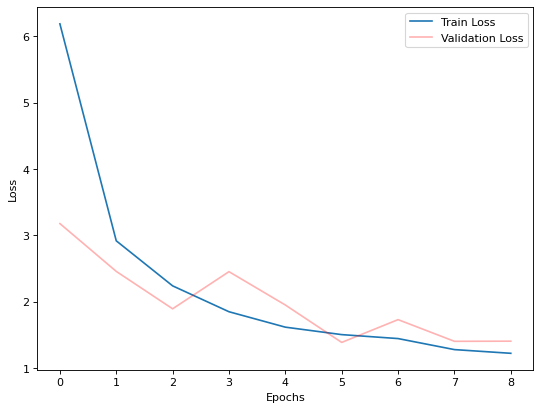

avg_val_loss_gender: [tensor(6.1907, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.9191, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.2399, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8496, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6171, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5046, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.4450, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.2787, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.2228, device='cuda:0', grad_fn=<AddBackward0>)] and avg_val_loss_age: 1.4021102681555502


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6), dpi=80)

# Plot loss trend
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list,'r',  label='Validation Loss', alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(f'avg_val_loss_gender: {train_loss_list} and avg_val_loss_age: {avg_val_loss_age}')

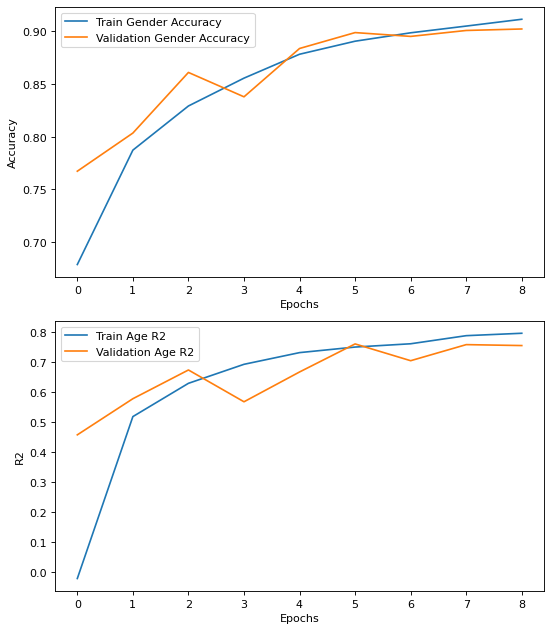

In [11]:
# Plot accuracy and R2 trends
plt.figure(figsize=(7, 8), dpi=80)

# Plot for gender
plt.subplot(2, 1, 1)
plt.plot(train_gender_accuracy_list, label='Train Gender Accuracy')
plt.plot(val_gender_accuracy_list, label='Validation Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for age
plt.subplot(2, 1, 2)
plt.plot(train_age_r2_list, label='Train Age R2')
plt.plot(val_age_r2_list, label='Validation Age R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

plt.tight_layout()
plt.show()

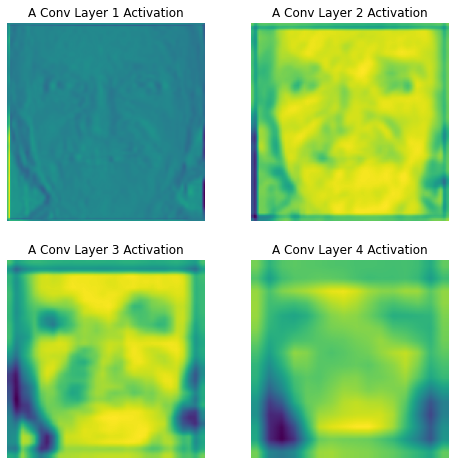

In [12]:
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
sample_images, _, _ = next(iter(validation_dataloader))

# Generate heatmaps
heatmaps = model.generate_heatmaps(sample_images.cuda())

# Plot the heatmaps
fig, axs = plt.subplots(2, int(len(heatmaps)/2), figsize=(8, 8))

# Plot the heatmaps
for i, heatmap in enumerate(heatmaps):
    row = i // 2
    col = i % 2
    axs[row, col].imshow(heatmap.squeeze().numpy(), cmap='viridis')
    axs[row, col].set_title(f'A Conv Layer {i + 1} Activation')
    axs[row, col].axis('off')

plt.show()

Test Loss: 1.3723
Test Gender Accuracy: 0.8986, Test Age R2 Score: 0.7731


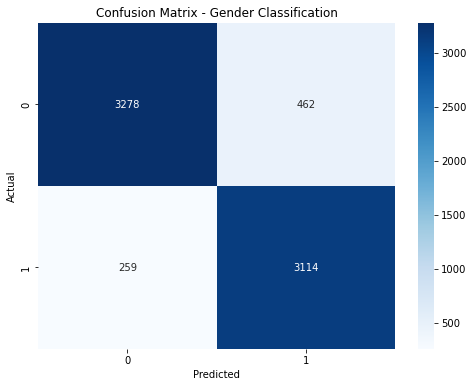

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct_gender_test = 0
    total_test = 0
    test_age_r2 = 0
    
    test_loss_gender = 0.0
    test_loss_age = 0.0
    total_test_samples = 0

    all_predicted_genders = []
    all_true_genders = []

    all_true_ages = []
    all_predicted_ages = []

    for idx, (inputs, gender_labels, age_labels) in enumerate(test_loader):
        age_labels = age_labels.float().view(-1, 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            gender_labels = gender_labels.cuda()
            age_labels = age_labels.cuda()
        gender_output, age_output = model(inputs)

        # Move the output in the same device of gender_labels
        gender_output = gender_output.to(gender_labels.device)
        age_output = age_output.to(age_labels.device)
        
        test_loss_gender += criterion_gender(gender_output, gender_labels).item()
        test_loss_age += criterion_age(age_output, age_labels).item()
        total_test_samples += len(inputs)

        # Calculate gender accuracy
        _, predicted_gender = torch.max(gender_output, 1)
        correct_gender_test += (predicted_gender == gender_labels).sum().item()
        total_test += gender_labels.size(0)

        all_predicted_genders.extend(predicted_gender.cpu().numpy())
        all_true_genders.extend(gender_labels.cpu().numpy())

        # Calculate age R2
        predicted_age = age_output.detach().cpu().numpy()
        test_age_r2 += r2_score(age_labels.cpu().numpy(), predicted_age)

        all_true_ages.extend(age_labels.cpu().numpy())
        all_predicted_ages.extend(predicted_age)

    test_gender_accuracy = correct_gender_test / total_test
    test_age_r2 /= len(test_loader)

    avg_test_loss_gender = test_loss_gender / total_test_samples
    avg_test_loss_age = test_loss_age / total_test_samples
    total_test_loss = avg_test_loss_gender + avg_test_loss_age

    print(f'Test Loss: {total_test_loss:.4f}')
    
    print(f'Test Gender Accuracy: {test_gender_accuracy:.4f}, '
          f'Test Age R2 Score: {test_age_r2:.4f}')

    # Plot the confusion matrix
    confusion_matrix = pd.crosstab(np.array(all_true_genders), np.array(all_predicted_genders), rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Gender Classification')
    plt.show()

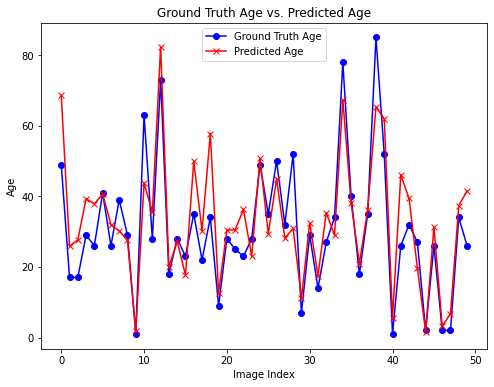

In [16]:
# Plot the predicted age vs. ground truth age
plt.figure(figsize=(8, 6))
plt.plot(all_true_ages[0:50], label='Ground Truth Age', color='blue', marker='o')
plt.plot(all_predicted_ages[0:50], label='Predicted Age', color='red', marker='x')
plt.xlabel('Image Index')
plt.ylabel('Age')
plt.title('Ground Truth Age vs. Predicted Age')
plt.legend()
plt.show()